# INTRO

In [29]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, matthews_corrcoef
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from scipy import sparse

In [30]:
y = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tesina/actual.csv')
print(y.shape)
y.head()

(72, 2)


,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


In [31]:
y.cancer.value_counts()

ALL    47
AML    25
Name: cancer, dtype: int64

Replace labels to be numeric (BINARY CLASSIFICATION):

In [32]:
y = y.replace({'ALL':0, 'AML':1})
labels = ['ALL','AML']

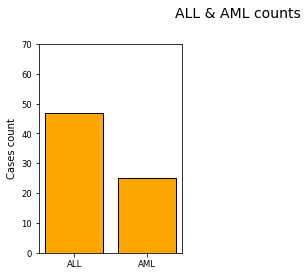

In [33]:
fig = plt.figure(figsize = (18, 4))
title = fig.suptitle("ALL & AML counts", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=1)

ax2 = fig.add_subplot(1,4, 2)
ax2.set_ylabel("Cases count") 
ww_q = y.cancer.value_counts()
ww_q = (list(ww_q.index), list(ww_q.values))
x_values = np.arange(0, len(labels) + 1, 1)
plt.xticks(x_values, labels)
ax2.set_ylim([0, 70])
ax2.tick_params(axis='both', which='major', labelsize=8.5)
bar2 = ax2.bar(ww_q[0], ww_q[1], color='orange', edgecolor='black', linewidth=1)

# DATA EVALUATION

## Import Train and Test data

In [6]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tesina/data_set_ALL_AML_train.csv')
print(df_train.shape)

df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tesina/data_set_ALL_AML_independent.csv')
print(df_test.shape)

(7129, 78)
(7129, 70)


In [7]:
df_train.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,5,call.4,6,call.5,7,call.6,8,call.7,9,call.8,10,call.9,11,call.10,12,call.11,13,call.12,14,call.13,15,call.14,16,call.15,17,call.16,18,call.17,19,call.18,20,call.19,21,call.20,22,call.21,23,call.22,24,call.23,25,call.24,26,call.25,27,call.26,34,call.27,35,call.28,36,call.29,37,call.30,38,call.31,28,call.32,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,-106,A,-138,A,-72,A,-413,A,5,A,-88,A,-165,A,-67,A,-92,A,-113,A,-107,A,-117,A,-476,A,-81,A,-44,A,17,A,-144,A,-247,A,-74,A,-120,A,-81,A,-112,A,-273,A,-20,A,7,A,-213,A,-25,A,-72,A,-4,A,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,-125,A,-85,A,-144,A,-260,A,-127,A,-105,A,-155,A,-93,A,-119,A,-147,A,-72,A,-219,A,-213,A,-150,A,-51,A,-229,A,-199,A,-90,A,-321,A,-263,A,-150,A,-233,A,-327,A,-207,A,-100,A,-252,A,-20,A,-139,A,-116,A,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,-76,A,215,A,238,A,7,A,106,A,42,A,-71,A,84,A,-31,A,-118,A,-126,A,-50,A,-18,A,-119,A,100,A,79,A,-157,A,-168,A,-11,A,-114,A,-85,A,-78,A,-76,A,-50,A,-57,A,136,A,124,A,-1,A,-125,A,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,168,A,71,A,55,A,-2,A,268,A,219,M,82,A,25,A,173,A,243,M,149,A,257,A,301,A,78,A,207,A,218,A,132,A,-24,A,-36,A,255,A,316,A,54,A,81,A,101,A,132,A,318,A,325,A,392,P,241,A,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,-230,A,-272,A,-399,A,-541,A,-210,A,-178,A,-163,A,-179,A,-233,A,-127,A,-205,A,-218,A,-403,A,-152,A,-146,A,-262,A,-151,A,-308,A,-317,A,-342,A,-418,A,-244,A,-439,A,-369,A,-377,A,-209,A,-396,A,-324,A,-191,A,-51,A,-139,A,-367,A,-188,A,-407,A


In [8]:
for col in df_train.columns:
  print(df_train[col].isnull().sum())

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


## Interchanging colums with row

This because the rows are the gene descriptors and the columns the patients. This has to be fixed.

Also, the column 'Call' is not explicitely described, so we can drop it.

In [9]:
train_to_keep = [col for col in df_train.columns if "call" not in col]
test_to_keep = [col for col in df_test.columns if "call" not in col]

X_train_temp = df_train[train_to_keep]
X_test_temp = df_test[test_to_keep]

In [10]:
train_columns_titles = ['Gene Description', 'Gene Accession Number', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', 
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38']

X_train_temp = X_train_temp.reindex(columns=train_columns_titles)

test_columns_titles = ['Gene Description', 'Gene Accession Number','39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51', '52', '53',  '54', '55', '56', '57', '58', '59',
       '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72']

X_test_temp = X_test_temp.reindex(columns=test_columns_titles)

In [11]:
X_train = X_train_temp.T
X_test = X_test_temp.T

print(X_train.shape) 
X_train.tail()

(40, 7129)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7089,7090,7091,7092,7093,7094,7095,7096,7097,7098,7099,7100,7101,7102,7103,7104,7105,7106,7107,7108,7109,7110,7111,7112,7113,7114,7115,7116,7117,7118,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
34,-20,-207,-50,101,-369,-529,14,-365,153,29,255,-769,-615,-199,232,222,-172,-287,16716,-66,172,-80,18,-182,169,-66,-243,-102,-45,-29,-419,-12,-686,-310,-293,-66,182,378,504,92,...,281,-444,21,349,536,657,16027,13940,538,521,84,8102,6639,956,1807,-230,11,283,18,383,71,82,157,339,198,323,496,-294,-1927,454,260,1009,-55,139,-57,834,557,-12,335,-65
35,7,-100,-57,132,-377,-478,-351,-290,283,247,146,-752,-702,-228,48,180,-141,-233,45492,-26,67,-72,7,-86,76,-55,-177,0,-79,-125,-281,122,-622,-307,-221,-79,45,372,2171,1752,...,420,-853,26,153,278,45,10462,16721,459,228,96,7771,4972,226,2051,-447,67,370,16,228,110,86,161,185,173,55,415,-413,-1959,391,93,336,-45,170,12,752,295,28,1558,-67
36,-213,-252,136,318,-209,-557,40,-243,119,-131,45,-902,-306,-258,465,298,-93,-516,23865,-38,-14,-191,7,-283,27,-131,-190,-32,9,-35,-370,-11,-517,-194,-161,216,227,722,580,130,...,294,119,270,172,616,559,26818,18306,1227,597,-117,16593,15921,536,5627,-331,-21,386,-8,356,27,-3,416,362,203,388,432,-257,-2149,412,234,1653,67,486,-88,1293,342,26,246,23
37,-25,-20,124,325,-396,-464,-221,-390,-1,358,-197,-852,-689,-175,-7,-156,-47,-397,17359,44,286,-73,-11,-272,118,-88,-206,-5,-68,-60,-278,38,-463,-228,10,1287,810,1378,2183,1563,...,239,962,425,418,479,691,17484,16806,1253,328,454,13591,13307,391,2441,-396,-51,228,-50,197,54,74,222,211,99,251,249,-430,-3452,393,146,486,-32,334,35,1733,304,12,3193,-33
38,-72,-139,-1,392,-324,-510,-350,-202,249,561,275,-785,-326,-47,-96,16,-140,-367,19406,113,227,-9,-13,-289,-25,-141,-114,-16,26,-59,-383,141,-588,-188,-74,207,260,720,819,513,...,299,-675,71,255,366,803,11184,16523,1030,236,21,11303,8768,-442,818,-365,-93,202,-91,267,3,20,-139,147,150,130,160,-381,-4082,286,103,1121,102,330,-112,1567,627,21,2520,0


In [12]:
X_train.columns = X_train.iloc[1]
X_train = X_train.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

X_test.columns = X_test.iloc[1]
X_test = X_test.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

print(X_train.shape)
print(X_test.shape)


(38, 7129)
(34, 7129)


In [13]:
X_train.tail()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,AFFX-BioC-5_st,AFFX-BioC-3_st,AFFX-BioDn-5_st,AFFX-BioDn-3_st,AFFX-CreX-5_st,AFFX-CreX-3_st,hum_alu_at,AFFX-DapX-5_at,AFFX-DapX-M_at,AFFX-DapX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-LysX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-PheX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-ThrX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-TrpnX-3_at,AFFX-HUMISGF3A/M97935_5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,...,X53065_f_at,X64177_f_at,X67491_f_at,X71345_f_at,X97444_f_at,Z80780_f_at,X00351_f_at,X01677_f_at,M31667_f_at,L41268_f_at,X99479_f_at,HG658-HT658_f_at,M94880_f_at,S80905_f_at,X03068_f_at,Z34822_f_at,U87593_f_at,U88902_cds1_f_at,AC002076_cds2_at,D64015_at,HG2510-HT2606_at,L10717_at,L34355_at,L78833_cds4_at,M13981_at,M21064_at,M93143_at,S78825_at,U11863_at,U29175_at,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
34,-20,-207,-50,101,-369,-529,14,-365,153,29,255,-769,-615,-199,232,222,-172,-287,16716,-66,172,-80,18,-182,169,-66,-243,-102,-45,-29,-419,-12,-686,-310,-293,-66,182,378,504,92,...,281,-444,21,349,536,657,16027,13940,538,521,84,8102,6639,956,1807,-230,11,283,18,383,71,82,157,339,198,323,496,-294,-1927,454,260,1009,-55,139,-57,834,557,-12,335,-65
35,7,-100,-57,132,-377,-478,-351,-290,283,247,146,-752,-702,-228,48,180,-141,-233,45492,-26,67,-72,7,-86,76,-55,-177,0,-79,-125,-281,122,-622,-307,-221,-79,45,372,2171,1752,...,420,-853,26,153,278,45,10462,16721,459,228,96,7771,4972,226,2051,-447,67,370,16,228,110,86,161,185,173,55,415,-413,-1959,391,93,336,-45,170,12,752,295,28,1558,-67
36,-213,-252,136,318,-209,-557,40,-243,119,-131,45,-902,-306,-258,465,298,-93,-516,23865,-38,-14,-191,7,-283,27,-131,-190,-32,9,-35,-370,-11,-517,-194,-161,216,227,722,580,130,...,294,119,270,172,616,559,26818,18306,1227,597,-117,16593,15921,536,5627,-331,-21,386,-8,356,27,-3,416,362,203,388,432,-257,-2149,412,234,1653,67,486,-88,1293,342,26,246,23
37,-25,-20,124,325,-396,-464,-221,-390,-1,358,-197,-852,-689,-175,-7,-156,-47,-397,17359,44,286,-73,-11,-272,118,-88,-206,-5,-68,-60,-278,38,-463,-228,10,1287,810,1378,2183,1563,...,239,962,425,418,479,691,17484,16806,1253,328,454,13591,13307,391,2441,-396,-51,228,-50,197,54,74,222,211,99,251,249,-430,-3452,393,146,486,-32,334,35,1733,304,12,3193,-33
38,-72,-139,-1,392,-324,-510,-350,-202,249,561,275,-785,-326,-47,-96,16,-140,-367,19406,113,227,-9,-13,-289,-25,-141,-114,-16,26,-59,-383,141,-588,-188,-74,207,260,720,819,513,...,299,-675,71,255,366,803,11184,16523,1030,236,21,11303,8768,-442,818,-365,-93,202,-91,267,3,20,-139,147,150,130,160,-381,-4082,286,103,1121,102,330,-112,1567,627,21,2520,0


## Label association
Split into train and test and use the first 38 of y to label those of the train and the others for test

In [14]:
X_train = X_train.reset_index(drop=True)
y_train = y[y.patient <= 38].reset_index(drop=True)

# Subset the rest for testing
X_test = X_test.reset_index(drop=True)
y_test = y[y.patient > 38].reset_index(drop=True)

X_train.iloc[:,0:3].describe()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at
count,38.000000,38.000000,38.000000
mean,-120.868421,-150.526316,-17.157895
std,109.555656,75.734507,117.686144
min,-476.000000,-327.000000,-307.000000
25%,-138.750000,-205.000000,-83.250000
50%,-106.500000,-141.500000,-43.500000
75%,-68.250000,-94.750000,47.250000
max,17.000000,-20.000000,265.000000


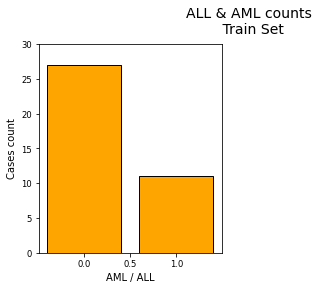

In [15]:
fig = plt.figure(figsize = (18, 4))
title = fig.suptitle("ALL & AML counts \n Train Set", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.5)

ax2 = fig.add_subplot(1,4, 2)
ax2.set_xlabel("AML / ALL")
ax2.set_ylabel("Cases count") 
ww_q = y_train.cancer.value_counts()
ww_q = (list(ww_q.index), list(ww_q.values))
ax2.set_ylim([0, 30])
ax2.tick_params(axis='both', which='major', labelsize=8.5)
bar2 = ax2.bar(ww_q[0], ww_q[1], color='orange', edgecolor='black', linewidth=1)

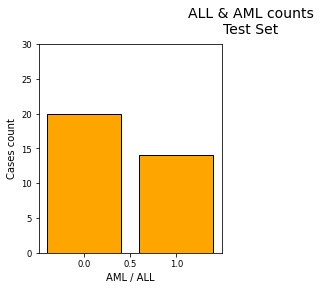

In [16]:
fig = plt.figure(figsize = (18, 4))
title = fig.suptitle("ALL & AML counts\nTest Set", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.5)

ax2 = fig.add_subplot(1,4, 2)
ax2.set_xlabel("AML / ALL")
ax2.set_ylabel("Cases count") 
ww_q = y_test.cancer.value_counts()
ww_q = (list(ww_q.index), list(ww_q.values))
ax2.set_ylim([0, 30])
ax2.tick_params(axis='both', which='major', labelsize=8.5)
bar2 = ax2.bar(ww_q[0], ww_q[1], color='orange', edgecolor='black', linewidth=1)

In [17]:
X_to_plot = X_train.join(y_train.iloc[:,1])
X_to_plot.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,AFFX-BioC-5_st,AFFX-BioC-3_st,AFFX-BioDn-5_st,AFFX-BioDn-3_st,AFFX-CreX-5_st,AFFX-CreX-3_st,hum_alu_at,AFFX-DapX-5_at,AFFX-DapX-M_at,AFFX-DapX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-LysX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-PheX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-ThrX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-TrpnX-3_at,AFFX-HUMISGF3A/M97935_5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,...,X64177_f_at,X67491_f_at,X71345_f_at,X97444_f_at,Z80780_f_at,X00351_f_at,X01677_f_at,M31667_f_at,L41268_f_at,X99479_f_at,HG658-HT658_f_at,M94880_f_at,S80905_f_at,X03068_f_at,Z34822_f_at,U87593_f_at,U88902_cds1_f_at,AC002076_cds2_at,D64015_at,HG2510-HT2606_at,L10717_at,L34355_at,L78833_cds4_at,M13981_at,M21064_at,M93143_at,S78825_at,U11863_at,U29175_at,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,cancer
0,-214,-153,-58,88,-295,-558,199,-176,252,206,-41,-831,-653,-462,75,381,-118,-565,15091,7,311,-231,21,-107,165,-78,-204,29,-61,-105,-366,-41,-346,-297,-109,-13,215,797,14538,9738,...,-763,172,149,341,788,21210,13771,598,396,245,14476,10882,701,2762,-325,-67,346,-68,229,-14,108,28,349,61,273,384,-306,-1827,1582,185,511,-125,389,-37,793,329,36,191,-37,0
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,19,-743,-239,-83,182,164,-141,-423,11038,37,134,-161,-21,-180,18,-120,-65,97,15,-49,-330,-41,-772,-259,-192,-219,116,433,615,115,...,51,154,418,433,736,21059,15097,563,171,-149,13686,11789,76,1567,-191,-88,290,14,194,56,303,-242,214,-28,143,231,-336,-2380,624,169,837,-36,442,-17,782,295,11,76,-14,0
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,19,-1135,-962,-232,208,432,84,-501,16692,183,378,-221,67,-203,238,-124,-161,36,-23,-80,-481,-65,-620,-269,-136,104,476,1474,5669,3272,...,-474,180,272,591,959,24292,17378,1808,363,325,6560,5023,804,1090,-258,9,220,-58,294,95,143,-25,464,513,238,720,-204,-1772,753,315,1199,33,168,52,1138,777,41,228,-41,0
3,-135,-114,265,12,-419,-585,158,-253,49,31,363,-934,-577,-214,142,271,-107,-101,15763,45,268,-27,43,-52,247,-116,-208,22,-10,-74,-240,-33,-560,-261,-366,-148,155,415,4850,2293,...,-336,325,149,173,431,17558,13818,576,455,594,8955,9567,367,1708,-357,45,430,-35,128,42,22,-131,342,142,277,307,-320,-2022,743,240,835,218,174,-110,627,170,-50,126,-91,0
4,-106,-125,-76,168,-230,-284,4,-122,70,252,155,-471,-490,-184,32,213,1,-260,18128,-28,118,-153,-8,-111,44,-88,-102,32,5,-18,-228,53,-348,-169,-156,-55,122,483,1284,2731,...,-56,279,183,259,605,18530,15619,65,122,126,8443,8512,182,1503,-78,29,159,18,71,42,44,-33,159,71,134,178,-182,-179,626,156,649,57,504,-26,250,314,14,56,-25,0


['U58048_at']


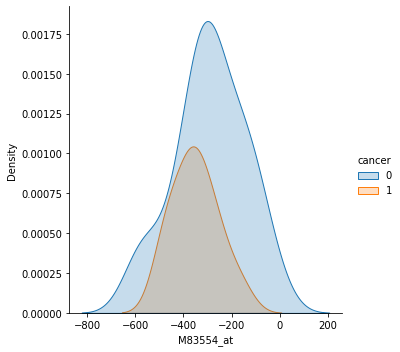

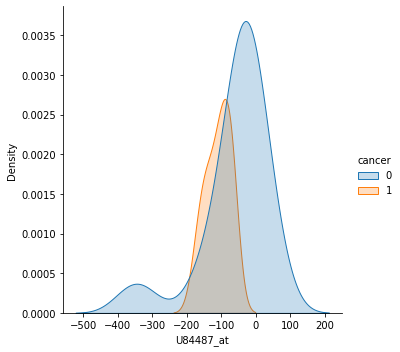

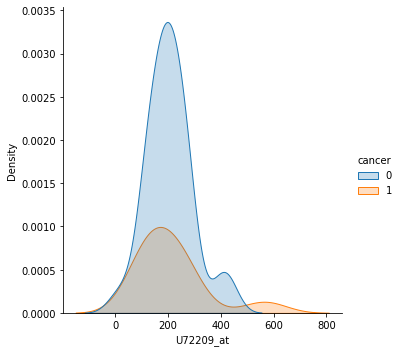

In [18]:
import seaborn as sns
print(X_to_plot.sample(axis="columns").columns.values)
sns.displot(X_to_plot, x="M83554_at", hue="cancer", kind="kde", fill=True)
sns.displot(X_to_plot, x="U84487_at", hue="cancer", kind="kde", fill=True)
sns.displot(X_to_plot, x="U72209_at", hue="cancer", kind="kde", fill=True)


## Scaling at same scale the values in dataset

In [19]:
X_train_fl = X_train.astype(float, 64)
X_test_fl = X_test.astype(float, 64)

# Apply the same scaling to both datasets
scaler = StandardScaler()
X_train_scl = scaler.fit_transform(X_train_fl)
X_test_scl = scaler.transform(X_test_fl) # note that we transform rather than fit_transform

# PCA
Threshold = 90% explained variance

In [23]:
pca = PCA()
pca.fit_transform(X_train)

array([[-4.12032149e+03,  8.43574289e+03, -1.39441668e+04, ...,
         2.51106855e+03,  3.92187680e+03,  1.48783302e-11],
       [ 1.86283598e+04,  1.44078238e+04,  1.66177453e+04, ...,
        -2.30960132e+02, -1.04099055e+03,  1.48783302e-11],
       [-1.58238732e+04,  1.40484268e+04,  4.73320627e+04, ...,
         5.48675197e+02, -2.26227734e+03,  1.48783302e-11],
       ...,
       [ 6.50848905e+04, -5.49595793e+04,  1.67854688e+04, ...,
         1.18708820e+01, -1.47894896e+03,  1.48783302e-11],
       [ 4.97670530e+04, -3.81956823e+04,  2.93511865e+03, ...,
         2.66462156e+03,  7.99461277e+02,  1.48783302e-11],
       [ 1.08241948e+04, -1.68550421e+04, -9.46017931e+02, ...,
        -2.04773331e+03, -1.96917341e+03,  1.48783302e-11]])

22  features explain around 90% of the variance.


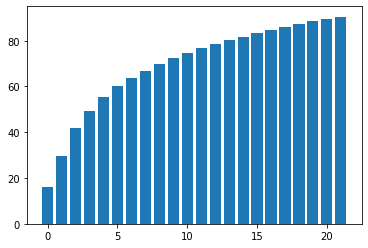

In [24]:
total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k = k + 1
    
print(k, " features explain around 90% of the variance.")

pca = PCA(n_components=k)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(k), var_exp);

[]

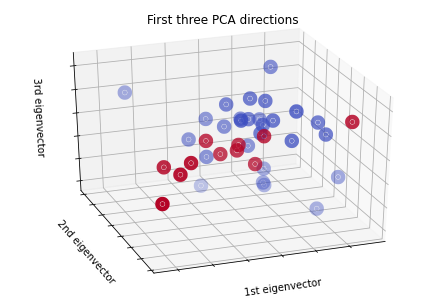

In [25]:
pca3 = PCA(n_components=3).fit(X_train)
X_train_reduced = pca3.transform(X_train)
X_test_reduced = pca3.transform(X_test)
plt.clf()
fig = plt.figure(1, figsize=(10,6 ))
ax = Axes3D(fig, elev=-150, azim=110,)
ax.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], X_train_reduced[:, 2], c = y_train.iloc[:,1], cmap = 'coolwarm', linewidths=10)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

Text(0.5, 1.0, '2D Transformation of the Above Graph ')

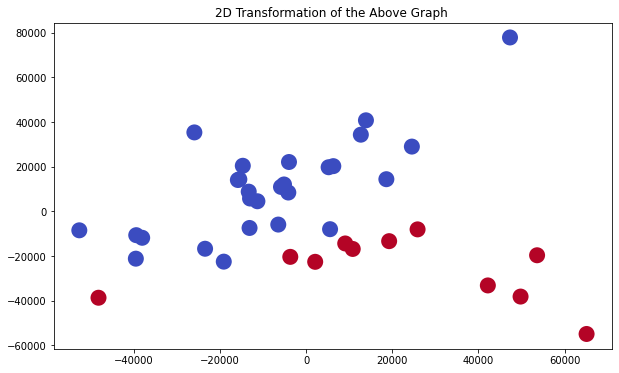

In [26]:
fig = plt.figure(1, figsize = (10, 6))
plt.scatter(X_train_reduced[:, 0],  X_train_reduced[:, 1], c = y_train.iloc[:,1], cmap = 'coolwarm', linewidths=10)
#plt.annotate('Note the Brown Cluster', xy = (30000,-2000))
plt.title("2D Transformation of the Above Graph ")



## Eigenvectors and eigenvalues

In [ ]:
print('NumPy covariance matrix: \n%s' %np.cov(X_train.T))

NumPy covariance matrix: 
[[ 1.20024417e+04  3.35607112e+03  1.62248080e+03 ... -4.17325747e+02
   1.87200277e+04 -1.86620199e+02]
 [ 3.35607112e+03  5.73571550e+03  9.94157895e+02 ... -4.81697013e+02
   1.13034296e+04 -5.68059744e+02]
 [ 1.62248080e+03  9.94157895e+02  1.38500284e+04 ... -6.18344239e+02
   1.12902532e+04 -2.87412518e+02]
 ...
 [-4.17325747e+02 -4.81697013e+02 -6.18344239e+02 ...  9.70873400e+02
   5.22119488e+01 -6.57652916e+01]
 [ 1.87200277e+04  1.13034296e+04  1.12902532e+04 ...  5.22119488e+01
   5.31068408e+05  2.35878805e+03]
 [-1.86620199e+02 -5.68059744e+02 -2.87412518e+02 ... -6.57652916e+01
   2.35878805e+03  9.51792319e+02]]


In [ ]:
cov_mat = np.cov(X_train.T)

In [ ]:
eigenvalues, eigenvectors = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eigenvectors[:5])
print('\nEigenvalues \n%s' %eigenvalues[:5])

Eigenvectors 
[[ 2.58603694e-04+0.00000000e+00j -7.79383098e-05+0.00000000e+00j
  -2.47701958e-04+0.00000000e+00j ...  1.46244761e-05-1.07677710e-05j
   1.46244761e-05+1.07677710e-05j  1.20821327e-05+0.00000000e+00j]
 [-1.60119310e-04+0.00000000e+00j  3.17385706e-04+0.00000000e+00j
  -4.49905521e-04+0.00000000e+00j ...  2.34595389e-06+2.07443844e-05j
   2.34595389e-06-2.07443844e-05j -3.34927828e-06+0.00000000e+00j]
 [-1.27803295e-04+0.00000000e+00j  8.27458395e-04+0.00000000e+00j
  -9.21894680e-04+0.00000000e+00j ... -3.97545637e-06+4.40475589e-06j
  -3.97545637e-06-4.40475589e-06j -4.68545871e-06+0.00000000e+00j]
 [-2.85445089e-03+0.00000000e+00j  1.66935951e-05+0.00000000e+00j
  -8.60656300e-04+0.00000000e+00j ... -7.34702423e-06-4.47584873e-06j
  -7.34702423e-06+4.47584873e-06j  1.24121132e-05+0.00000000e+00j]
 [-4.92742801e-04+0.00000000e+00j -8.76062459e-04+0.00000000e+00j
  -3.17304854e-04+0.00000000e+00j ...  2.58800955e-06+1.19013920e-05j
   2.58800955e-06-1.19013920e-05j -1.6

In [ ]:
len(eigenvalues)

In [ ]:
total_of_eigenvalues = sum(eigenvalues)
varariance = [(i / total_of_eigenvalues)*100 for i in sorted(eigenvalues, reverse=True)]

varariance[:50]

[(16.108455951939966+0j),
 (13.700077562695325+0j),
 (11.971823111275501+0j),
 (7.469116743416296+0j),
 (6.077554061442305+0j),
 (4.747469661912821+0j),
 (3.657450641842091+0j),
 (3.2284334800492394+0j),
 (2.887610237623723+0j),
 (2.4463242618480443+0j),
 (2.273929856620894+0j),
 (2.0891512780687593+0j),
 (1.7828834967697862+0j),
 (1.7377326507436741+0j),
 (1.6049811546864345+0j),
 (1.5508515283704893+0j),
 (1.3837036927280353+0j),
 (1.3140519013267737+0j),
 (1.2819641552886645+0j),
 (1.10973923121723+0j),
 (1.0638635973923307+0j),
 (1.0040731115633381+0j),
 (0.9557867421556979+0j),
 (0.887495431085792+0j),
 (0.867645969026074+0j),
 (0.8162802098547732+0j),
 (0.7963102651378895+0j),
 (0.7424852396732896+0j),
 (0.7109324857358553+0j),
 (0.6293203261696185+0j),
 (0.6058239445563507+0j),
 (0.49040862872544333+0j),
 (0.4565532985521736+0j),
 (0.4282300281117893+0j),
 (0.4057130490681114+0j),
 (0.3711845888526713+0j),
 (0.34458842447278765+0j),
 (1.054125973610591e-15+0j),
 (1.0020928865791

/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


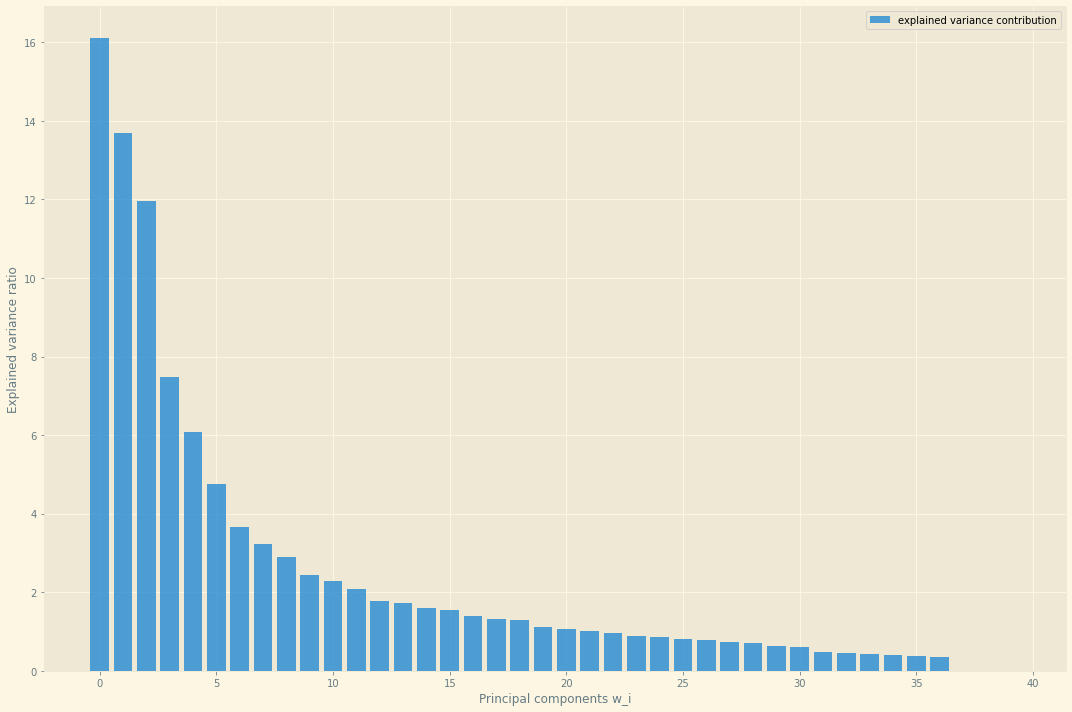

In [ ]:
with plt.style.context('Solarize_Light2'):
    plt.figure(figsize=(15, 10))

    plt.bar(range(40), varariance[:40], alpha=0.8, align='center',
            label='explained variance contribution')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components w_i')
    plt.legend(loc='best')
    plt.tight_layout()

# MODELS

## k-Means Clustering

K-means accuracy: 0.853
K-means MCC: 0.717


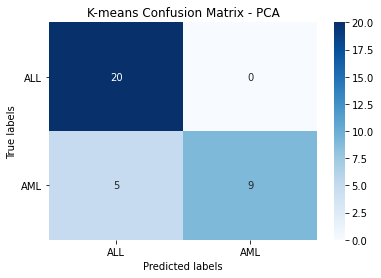

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42).fit(X_train_pca)
km_pred = kmeans.predict(X_test_pca)

print('K-means accuracy:', round(accuracy_score(y_test.iloc[:,1], km_pred), 3))
print('K-means MCC:', round(matthews_corrcoef(y_test.iloc[:,1], km_pred), 3))
#print(classification_report(y_test.iloc[:,1], km_pred, target_names=labels))
cm_km = confusion_matrix(y_test.iloc[:,1], km_pred)

ax = plt.subplot()
sns.heatmap(cm_km, annot=True, ax = ax, fmt='g', cmap='Blues') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('K-means Confusion Matrix - PCA') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);



Text(0.5, 1.0, '2D Transformation of input Data ')

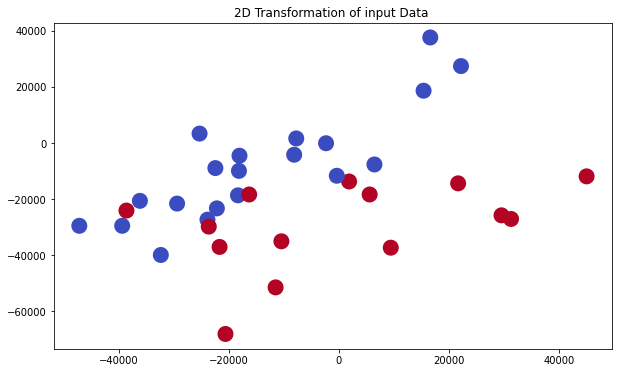

In [ ]:
fig = plt.figure(1, figsize = (10, 6))
plt.scatter(X_test_pca[:, 0],  X_test_pca[:, 1], c = y_test.iloc[:,1], cmap = 'coolwarm', linewidths=10)
#plt.annotate('Note the Brown Cluster', xy = (30000,-2000))
plt.title("2D Transformation of input Data ")

[]

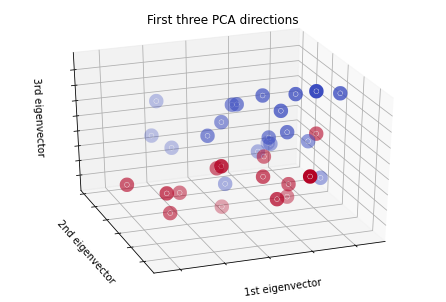

In [ ]:
plt.clf()
fig = plt.figure(1, figsize=(10,6 ))
ax = Axes3D(fig, elev=-150, azim=110,)
ax.scatter(X_test_reduced[:, 0], X_test_reduced[:, 1], X_test_reduced[:, 2], c = y_test.iloc[:,1], cmap = 'coolwarm', linewidths=10)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

Text(0.5, 1.0, '2D Transformation of predicted Data')

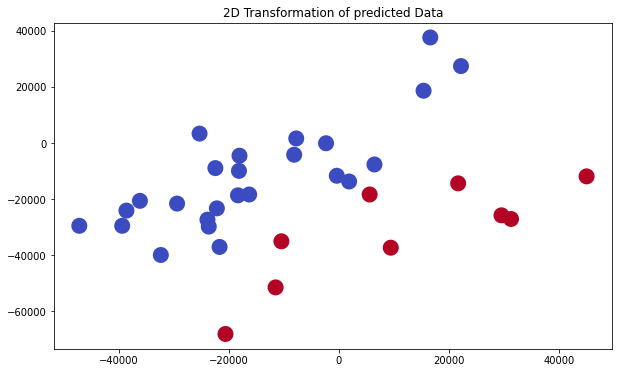

In [ ]:
fig = plt.figure(1, figsize = (10, 6))
plt.scatter(X_test_pca[:, 0],  X_test_pca[:, 1], c = km_pred, cmap = 'coolwarm', linewidths=10)
#plt.annotate('Note the Brown Cluster', xy = (30000,-2000))
plt.title("2D Transformation of predicted Data")



In [ ]:
plt.clf()
fig = plt.figure(1, figsize=(10,6 ))
ax = Axes3D(fig, elev=-150, azim=110,)
ax.scatter(X_test_reduced[:, 0], X_train_reduced[:, 1], X_train_reduced[:, 2], c = y_train.iloc[:,1], cmap = 'coolwarm', linewidths=10)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

## Naive Bayes with Gaussian

Naive Bayes accuracy: 0.941
Naive Bayes MCC: 0.879


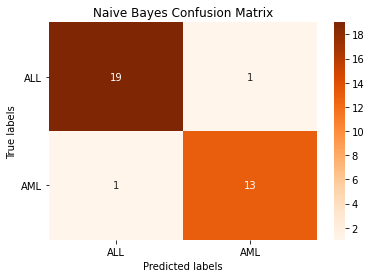

In [ ]:
nb_model = GaussianNB()

nb_model.fit(X_train_pca, y_train.iloc[:,1])

nb_pred = nb_model.predict(X_test_pca)

print('Naive Bayes accuracy:', round(accuracy_score(y_test.iloc[:,1], nb_pred), 3))
print('Naive Bayes MCC:', round(matthews_corrcoef(y_test.iloc[:,1], nb_pred), 3))

cm_nb =  confusion_matrix(y_test.iloc[:,1], nb_pred)

ax = plt.subplot()
sns.heatmap(cm_nb, annot=True, ax = ax, fmt='g', cmap='Oranges') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Naive Bayes Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

## Logistic Regression

Best Parameters:
 {'C': 1, 'penalty': 'l1'}
Logistic Regression accuracy: 0.912
Logistic Regression MCC score: 0.827


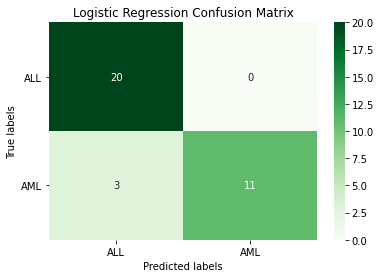

In [ ]:
log_grid = {'C': [1e-03, 1e-2, 1e-1, 1, 10], 
                 'penalty': ['l1', 'l2']}

log_estimator = LogisticRegression(solver='liblinear')

log_model = GridSearchCV(estimator=log_estimator, 
                  param_grid=log_grid, 
                  cv=3,
                  scoring='accuracy')

log_model.fit(X_train_scl, y_train.iloc[:,1])

print("Best Parameters:\n", log_model.best_params_)

# Select best log model
best_log = log_model.best_estimator_

# Make predictions using the optimised parameters
log_pred = best_log.predict(X_test_scl)

print('Logistic Regression accuracy:', round(accuracy_score(y_test.iloc[:,1], log_pred), 3))
print('Logistic Regression MCC score:', round(matthews_corrcoef(y_test.iloc[:,1], log_pred), 3))

cm_log =  confusion_matrix(y_test.iloc[:,1], log_pred)

ax = plt.subplot()
sns.heatmap(cm_log, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Logistic Regression Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

## SVM

Best Parameters:
 {'C': 0.1, 'decision_function_shape': 'ovr', 'gamma': 1, 'kernel': 'linear'}
SVM accuracy: 0.941
SVM MCC score: 0.887


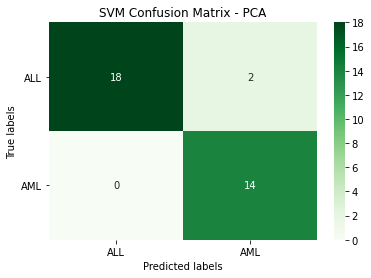

In [27]:
svm_param_grid = {'C': [0.1, 0.5, 1, 10, 100], 'gamma': [1, 0.75, 0.5, 0.25, 0.1, 0.01, 0.001], "kernel": ["linear", "rbf", "poly", "sigmoid"], 
                  "decision_function_shape" : ["ovr"]} 
svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=3)
svm_grid.fit(X_train_pca, y_train.iloc[:,1])

print("Best Parameters:\n", svm_grid.best_params_)
best_svc = svm_grid.best_estimator_
svm_pred = best_svc.predict(X_test_pca)

print('SVM accuracy:', round(accuracy_score(y_test.iloc[:,1], svm_pred), 3))
print('SVM MCC score:', round(matthews_corrcoef(y_test.iloc[:,1], svm_pred), 3))

cm_svm =  confusion_matrix(y_test.iloc[:,1], svm_pred)

ax = plt.subplot()
sns.heatmap(cm_svm, annot=True, ax = ax, fmt='g', cmap='Greens') 

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('SVM Confusion Matrix - PCA') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

Best Parameters:
 {'C': 0.1, 'decision_function_shape': 'ovr', 'gamma': 1, 'kernel': 'linear'}
SVM accuracy: 0.912
SVM MCC score: 0.827


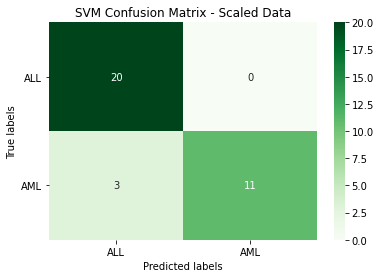

In [ ]:
svm_nopca_param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10], "kernel": ["linear"], 
                  "decision_function_shape" : ["ovr"]} 
svm_grid = GridSearchCV(SVC(), svm_nopca_param_grid, cv=3)
svm_grid.fit(X_train_scl, y_train.iloc[:,1])

print("Best Parameters:\n", svm_grid.best_params_)
best_svc = svm_grid.best_estimator_
svm_pred = best_svc.predict(X_test_scl)

print('SVM accuracy:', round(accuracy_score(y_test.iloc[:,1], svm_pred), 3))
print('SVM MCC score:', round(matthews_corrcoef(y_test.iloc[:,1], svm_pred), 3))

cm_svm =  confusion_matrix(y_test.iloc[:,1], svm_pred)

ax = plt.subplot()
sns.heatmap(cm_svm, annot=True, ax = ax, fmt='g', cmap='Greens') 

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('SVM Confusion Matrix - Scaled Data') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

In [46]:
from sklearn.svm import SVC
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
'''digits = datasets.load_digits()
X = digits.data
y = digits.target

clf_ = SVC(kernel='rbf')
Cs = [1, 10, 100, 1000]
Gammas = [1e-3, 1e-4]
clf = GridSearchCV(clf_,
            dict(C=Cs,
                 gamma=Gammas),
                 cv=2,
                 pre_dispatch='1*n_jobs',
                 n_jobs=1)

clf.fit(X, y)'''

plt(svm_grid.cv_results_, change=('C', 'gamma'),subset={'kernel': 'linear'})

TypeError: ignored

## Random Forest

Best Parameters:
 {'bootstrap': True, 'max_features': 0.6, 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 60}
Random Forest accuracy: 0.882


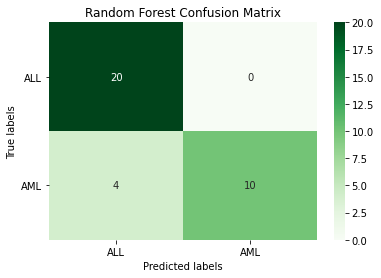

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt', 0.6, 0.65, 0.7, 0.75, 0.8]
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]

param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_estimator = RandomForestClassifier(random_state=0)
rf_model = GridSearchCV(estimator=rf_estimator, param_grid=param_dist, cv=3, scoring='accuracy')
rf_model.fit(X_train, y_train.iloc[:,1])

print("Best Parameters:\n", rf_model.best_params_)

rf_model_best = rf_model.best_estimator_

rf_pred = rf_model_best.predict(X_test)

print('Random Forest accuracy:', round(accuracy_score(y_test.iloc[:,1], rf_pred), 3))

cm_rf = confusion_matrix(y_test.iloc[:,1], rf_pred)

ax = plt.subplot()
sns.heatmap(cm_rf, annot=True, ax = ax, fmt='g', cmap='Greens') 

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Random Forest Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

Random Forest accuracy: 0.824


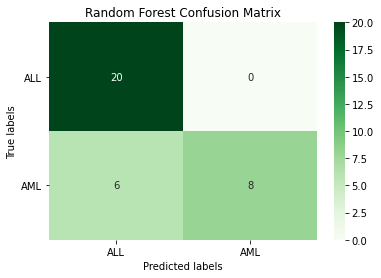

In [ ]:
rf_estimator = RandomForestClassifier(random_state=42)
rf_estimator.fit(X_train_pca, y_train.iloc[:,1])
rf_pred = rf_estimator.predict(X_test_pca)

print('Random Forest accuracy:', round(accuracy_score(y_test.iloc[:,1], rf_pred), 3))

cm_rf = confusion_matrix(y_test.iloc[:,1], rf_pred)

ax = plt.subplot()
sns.heatmap(cm_rf, annot=True, ax = ax, fmt='g', cmap='Greens') 

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Random Forest Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

In [ ]:
feats = {}
for feature, importance in zip(X_train.columns, rf_estimator.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})

importances_red = importances[importances['Gini-Importance']>0]
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances_red['Gini-Importance'], y=importances_red['Features'], data=importances_red, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances_red)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt', 0.6, 0.65, 0.7, 0.75, 0.8]
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True]

param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rfc_2 = RandomForestClassifier(random_state=42)
rs = RandomizedSearchCV(rfc_2, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=42,
                        scoring='accuracy')

rs.fit(X_train_scl, y_train.iloc[:,1])
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.7min finished


{'bootstrap': True,
 'max_depth': 3,
 'max_features': 0.6,
 'min_samples_leaf': 2,
 'min_samples_split': 12,
 'n_estimators': 400}

In [ ]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,400,12,2,0.6,3,True,0.923077,1
1,700,7,2,0.6,14,True,0.923077,1
2,700,7,2,sqrt,1,True,0.871795,3
3,200,2,2,sqrt,7,True,0.869658,4
4,500,2,7,0.8,12,True,0.846154,5
5,200,12,7,0.7,10,True,0.820513,6
6,1000,2,23,0.6,11,True,0.711538,7
7,900,28,39,0.65,7,True,0.711538,7
8,300,50,34,0.6,2,True,0.711538,7
9,800,28,39,0.75,6,True,0.711538,7


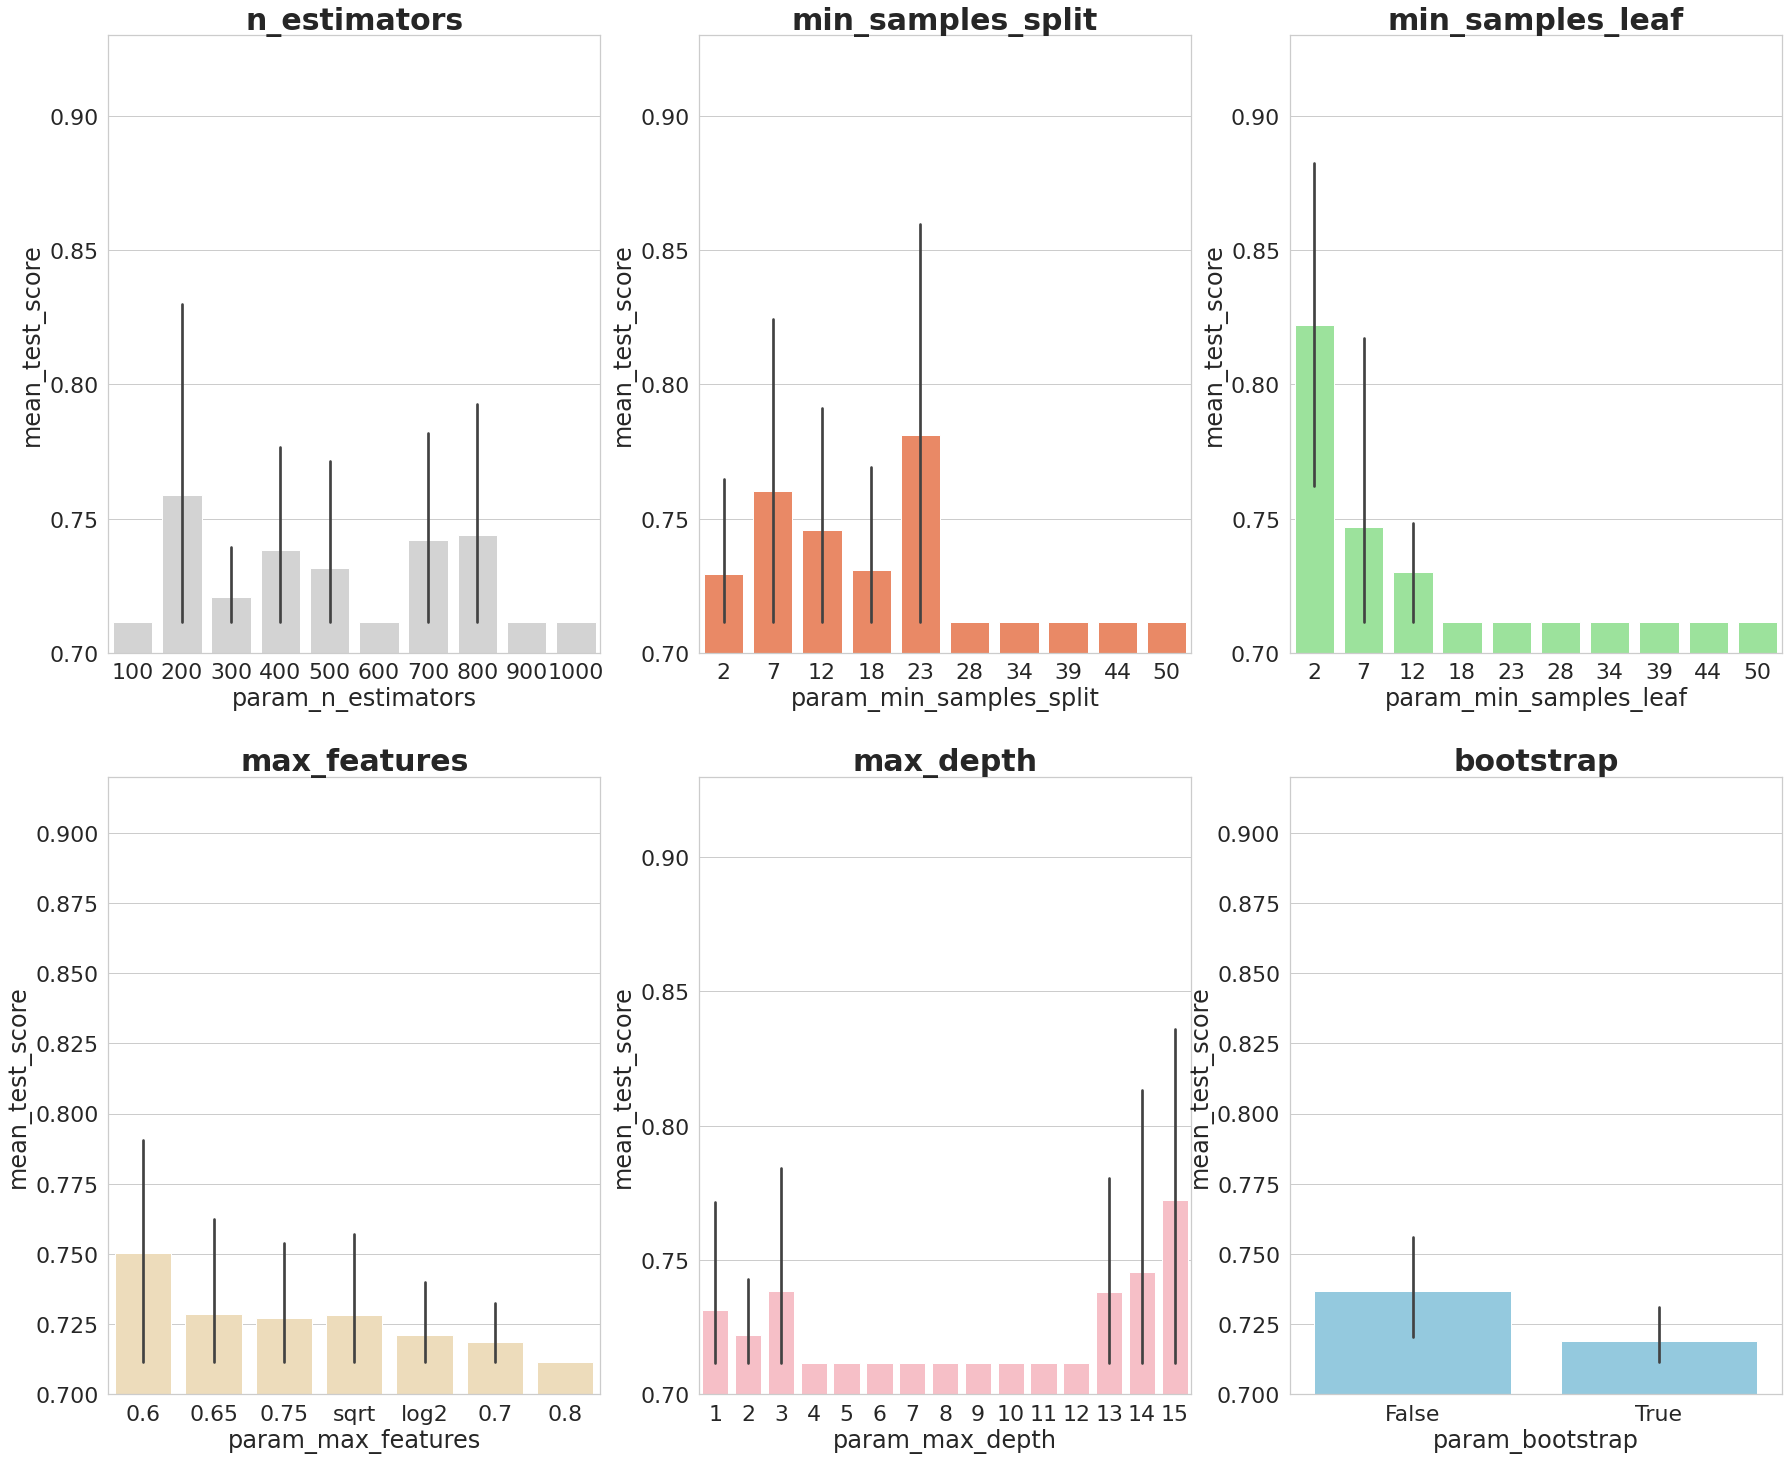

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.70,.93])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.70,.93]) 
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.70,.93]) 
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.70,.92]) 
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.70,.93]) 
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.70,.92])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import 

In [ ]:
rf_estimator = RandomForestClassifier(random_state=42)
rf_estimator.fit(X_train_scl, y_train.iloc[:,1])
rf_pred = rf_estimator.predict(X_test_scl)

conf_matrix_baseline = pd.DataFrame(confusion_matrix(y_test.iloc[:,1], rf_pred), index = ['actual ALL', 'actual AML'], columns = ['predicted ALL', 'predicted AML'])
display(conf_matrix_baseline)
display('Baseline Random Forest accuracy score', accuracy_score(y_test.iloc[:,1], rf_pred))
display('Baseline Random Forest MCC score', matthews_corrcoef(y_test.iloc[:,1], rf_pred))

,predicted ALL,predicted AML
actual ALL,20,0
actual AML,6,8


'Baseline Random Forest accuracy score'

0.8235294117647058

'Baseline Random Forest MCC score'

0.6629935441317959

"\ndisplay(conf_matrix_baseline_pca)\ndisplay('Baseline Random Forest With PCA recall score', recall_score(y_test.iloc[:,1], rf_pred_pca))\ndisplay(conf_matrix_tuned_pca)\ndisplay('Hyperparameter Tuned Random Forest With PCA Reduced Dimensionality recall score', recall_score(y_test.iloc[:,1], rf_best_pca))\n"

In [ ]:
rf_estimator = RandomForestClassifier(random_state=42)
rf_estimator.fit(X_train_pca, y_train.iloc[:,1])
rf_pred_pca = rf_estimator.predict(X_test_pca)

conf_matrix_baseline_pca = pd.DataFrame(confusion_matrix(y_test.iloc[:,1], rf_pred_pca), index = ['actual ALL', 'actual AML'], columns = ['predicted ALL', 'predicted AML'])
display(conf_matrix_baseline_pca)
display('Baseline Random Forest With PCA accuracy score', accuracy_score(y_test.iloc[:,1], rf_pred_pca))
display('Baseline Random Forest With PCA MCC score', matthews_corrcoef(y_test.iloc[:,1], rf_pred_pca))

,predicted ALL,predicted AML
actual ALL,20,0
actual AML,6,8


'Baseline Random Forest With PCA accuracy score'

0.8235294117647058

'Baseline Random Forest With PCA MCC score'

0.6629935441317959

In [ ]:
rf_tuned = rs.best_estimator_.predict(X_test)
conf_matrix_tuned = pd.DataFrame(confusion_matrix(y_test.iloc[:,1], rf_tuned), index = ['actual ALL', 'actual AML'], columns = ['predicted ALL', 'predicted AML'])
display(conf_matrix_tuned)
display('Tuned Random Forest accuracy score', accuracy_score(y_test.iloc[:,1], rf_tuned))
display('Tuned Random Forest MCC score', matthews_corrcoef(y_test.iloc[:,1], rf_tuned))

,predicted ALL,predicted AML
actual ALL,20,0
actual AML,1,13


'Tuned Random Forest accuracy score'

0.9705882352941176

'Tuned Random Forest MCC score'

0.9404008408634048

In [ ]:
rf_tuned_pca = rs.best_estimator_.predict(X_test_pca)

conf_matrix_tuned_pca = pd.DataFrame(confusion_matrix(y_test.iloc[:,1], rf_tuned_pca), index = ['actual ALL', 'actual AML'], columns = ['predicted ALL', 'predicted AML'])
display(conf_matrix_tuned_pca)
display('Tuned Random Forest with PCA accuracy score', accuracy_score(y_test.iloc[:,1], rf_tuned_pca))
display('Tuned Random Forest with PCA MCC score', matthews_corrcoef(y_test.iloc[:,1], rf_tuned_pca))

,predicted ALL,predicted AML
actual ALL,12,8
actual AML,1,13


'Tuned Random Forest with PCA accuracy score'

0.7352941176470589

'Tuned Random Forest with PCA MCC score'

0.5353050940299381